# <U>Notebook Table Of Contents<u>

**1. Loading Miles data <br>**
**2. Loading CFLIB data <br>**
**3. Loading JHC data <br>**
**4. Loading LAMOST data <br>**

In [1]:
#pip install astropy

In [2]:
#pip install astroquery

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gzip

#astro modules 
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.io import fits
from astropy import units as u

#supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
## FITS file handling tutorial: https://www.youtube.com/watch?v=_DzSIeruotQ
## astroML resources: https://www.astroml.org/book_figures/chapter1/fig_SDSS_sspp.html#book-fig-chapter1-fig-sdss-sspp

-------
# 1. Loading MILES data  
http://miles.iac.es/pages/stellar-libraries/miles-library.php

First loading in one file to check formatting:

In [66]:
# Load the FITS file
fits_file = fits.open('../data/MILES_Library/s0010.fits')
fits_file.info()

Filename: ../data/MILES_Library/s0010.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (4367, 1)   float32   


In [67]:
fits_file[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4367 / length of data axis 1                          
NAXIS2  =                    1 / length of data axis 2                          
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT ----------------------------------------------------------------------  
COMMENT ************************** REDUCEME HEADER ***************************  
COMMENT ----------------------------------------------------------------------  
HISTORY Date: 06/10/**                                                          
CRPIX1  =                 1.00                                                  
CRVAL1  =            3500.00

In [68]:
spectra_data = fits_file[0].data
spectra_data

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [69]:
spectra_data = spectra_data.tolist()[0]
#spectra_data

In [70]:
spectra_object = fits_file[0].header['OBJECT']

In [71]:
#first wavelength
wave_start = fits_file[0].header['CRVAL1']

#number of wavlengths
wave_num = fits_file[0].header['NAXIS1']

#steps between each wavelength
wave_steps = fits_file[0].header['CDELT1']

#end wavelength 
wave_end = wave_start + (wave_num * wave_steps)

In [72]:
miles_wavelengths = np.arange(wave_start, wave_end, wave_steps)

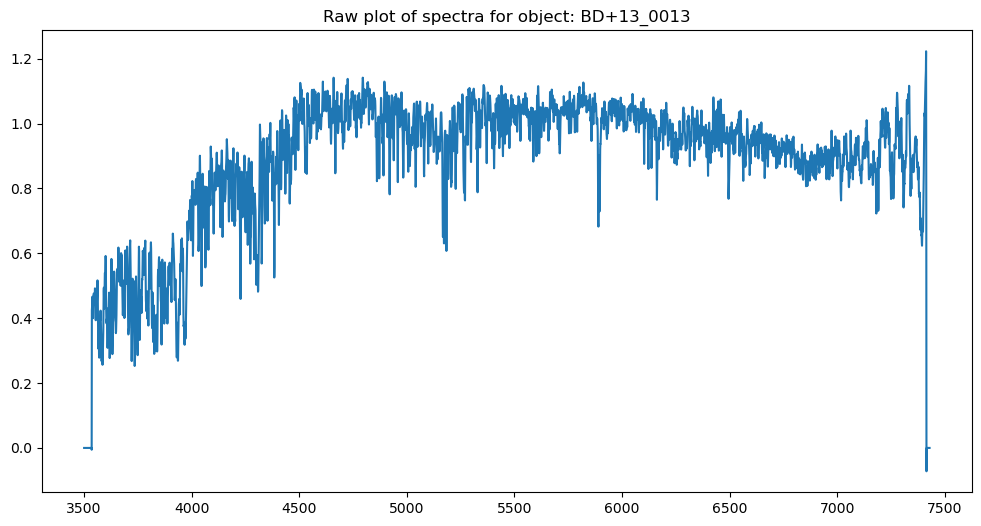

In [73]:
#plotting the spectrum of one star from the SDSS dataset
plt.figure(figsize=(12,6))
plt.title(f'Raw plot of spectra for object: {spectra_object}')
plt.plot(miles_wavelengths, spectra_data)
plt.show()

In [74]:
#trimming spectra to remove erroneous values at beginning and end of spectra
spectra_data = spectra_data[40:4345]
miles_wavelengths = miles_wavelengths[40:4345]

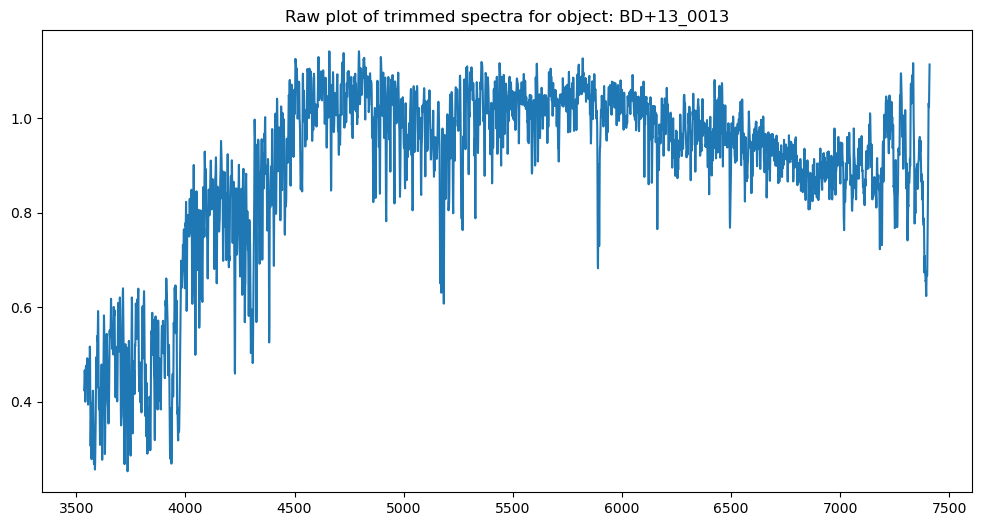

In [75]:
#plotting the spectrum of one star from the MILES dataset
plt.figure(figsize=(12,6))
plt.title(f'Raw plot of trimmed spectra for object: {spectra_object}')
plt.plot(miles_wavelengths ,spectra_data)
plt.show()

#### processing all MILES fits files

In [16]:
#defining directory where MILES files aSre stored
directory = '../data/MILES_Library/'

#initialising dictionary to store dataframes
spectra_dataframes = {}
#initialising number of files iterator
i=0
#initialising onjectID list
objectIDs = []

for filename in os.listdir(directory):
    filepath = os.path.join(directory,filename)
    if os.path.isfile(filepath):
        # Load the FITS file
        #print(f'processing {filename}')
        with fits.open(filepath) as fits_file:
            fits_file = fits.open(filepath)
            
            #extracting spectra data from fits file
            spectra_data = fits_file[0].data
            spectra_data = spectra_data.tolist()[0]
            
            #getting the object name 
            spectra_object = fits_file[0].header['OBJECT']
            spectra_data = spectra_data[40:4345]

            #creating a dataframe containing both wavelength and flux values
            spectra_vecs =  pd.DataFrame({'wavelength':wavelengths,'flux':spectra_data}) 
            
            #creating a dictionary of dataframes
            spectra_dataframes['df_'+spectra_object] = spectra_vecs
            
            #appending specIDs to array
            objectIDs.append(spectra_object)
        i+=1
        
print(f'finished processing {i} files')

finished processing 985 files


In [17]:
print(f'first wavelength in MILES spectra: {wavelengths[0]}')
print(f'last wavelength in MILES spectra: {wavelengths[-1]}')

first wavelength in MILES spectra: 3536.0000000000036
last wavelength in MILES spectra: 7409.600000000395


In [18]:
#creating dataframe consisting of objectID and flux values
flux_df = pd.DataFrame({'objectID':[],'flux':[]})
for key,value in spectra_dataframes.items():
    objectID = key[3:]
    new_df = pd.DataFrame({'objectID':objectID,'flux':[list(value.flux)]})
    flux_df = pd.concat([flux_df, new_df])

flux_df.set_index('objectID', inplace=True)  

In [19]:
flux_df.head()

,flux
objectID,
HD224930,"[0.6613548994064331, 0.6502922773361206, 0.668..."
HD225212,"[0.07035478949546814, 0.08019780367612839, 0.0..."
HD225239,"[0.6423735618591309, 0.659354031085968, 0.6719..."
HD000004,"[0.021027246490120888, 0.6495805978775024, 0.6..."
HD000249,"[0.28820979595184326, 0.276512086391449, 0.289..."


- Now that I have the spectra processed and loaded into the above dataframe, I need to determine the MK stellar class associated with each object, as well as determine the atmospheric parameters (i.e. effective temperature, logg- surface gravity, and metallicity). To do this, I will look up the objectIDs from the **SIMBAD** database. 
- **SIMBAD**: SIMBAD (the Set of Identifications, Measurements and Bibliography for Astronomical Data) is an astronomical database of objects beyond the Solar System. It is maintained by the Centre de données astronomiques de Strasbourg (CDS), France.

Notes on SIMBAD: 

- https://simbad.u-strasbg.fr/Pages/guide/ch02.htx
- https://simbad.u-strasbg.fr/Pages/guide/sim-fscript.htx
- https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD224930&submit=SIMBAD+search
- https://rishipaudel.wordpress.com/2018/03/07/python-script-to-use-astroquery-to-get-the-information-of-stars-and-other-targets-in-simbad-vizier/ 


In [41]:
stellar_params = pd.DataFrame({'object_id':[],'sp_type':[],'teff':[],'logg':[],'metallicity':[]})
stellar_params.set_index('object_id', inplace=True)

In [42]:
#adding fields to be returned from query
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype', 'fe_h') 

In [43]:
#querying simbad for all objectIDs and concatenating to stellar_params dataframe
for objectID in objectIDs:
    res = customSimbad.query_object(objectID)
    if not res is None:
        res = res.to_pandas()
        res = res[['SP_TYPE','Fe_H_Teff','Fe_H_log_g','Fe_H_Fe_H']]
        res.columns = ['sp_type', 'teff', 'logg',  'metallicity']
        res['object_id'] = objectID
    elif res is None:
        res = pd.DataFrame({'object_id':[objectID],'sp_type':[None],'teff':[None],'logg':[None],'metallicity':[None]})
    res.set_index('object_id', inplace=True)
    stellar_params = pd.concat([stellar_params,res])  

In [23]:
stellar_params.head()

,sp_type,teff,logg,metallicity
object_id,,,,
HD224930,G5VbFe-2,5474.0,4.340,-0.82
HD225212,K3Ib,4190.0,-0.222,NaN
HD225239,G3,5610.0,3.760,-0.48
HD000004,F0,6380.0,3.010,0.30
HD000249,K0,4790.0,2.950,-0.08


In [46]:
len(stellar_params)

985

In [47]:
stellar_params.isnull().sum()

sp_type        53
teff           53
logg           53
metallicity    53
dtype: int64

In [48]:
#dropping any spectra that still have null values 
stellar_params = stellar_params.dropna()

In [49]:
len(stellar_params)

932

In [50]:
##merging stellar_params with spectra fluxes
miles_data_all = pd.merge(stellar_params, flux_df, left_index=True, right_index=True)

In [51]:
miles_data_all.head()

,sp_type,teff,logg,metallicity,flux
HD224930,G5VbFe-2,5501.0,4.92,-0.98,"[0.6613548994064331, 0.6502922773361206, 0.668..."
HD225212,K3Ib,4197.0,1.59,-0.03,"[0.07035478949546814, 0.08019780367612839, 0.0..."
HD225239,G3,5869.0,3.98,-0.23,"[0.6423735618591309, 0.659354031085968, 0.6719..."
HD000004,F0,6798.0,3.87,-0.17,"[0.021027246490120888, 0.6495805978775024, 0.6..."
HD000249,K0,4742.0,2.78,-0.12,"[0.28820979595184326, 0.276512086391449, 0.289..."


In [52]:
miles_data_all.isnull().sum()

sp_type        0
teff           0
logg           0
metallicity    0
flux           0
dtype: int64

In [53]:
len(miles_data_all.flux[0])

4305

In [54]:
#saving as csv
#miles_data_all.to_csv('../data/derived_tables/miles_data')

#saving as pickle file
miles_data_all.to_pickle('../data/derived_tables/miles_data.pkl')

#saving wavelengths to csv 
pd.DataFrame({'wavelength':miles_wavelengths}).to_csv('../data/derived_tables/miles_wave.csv')

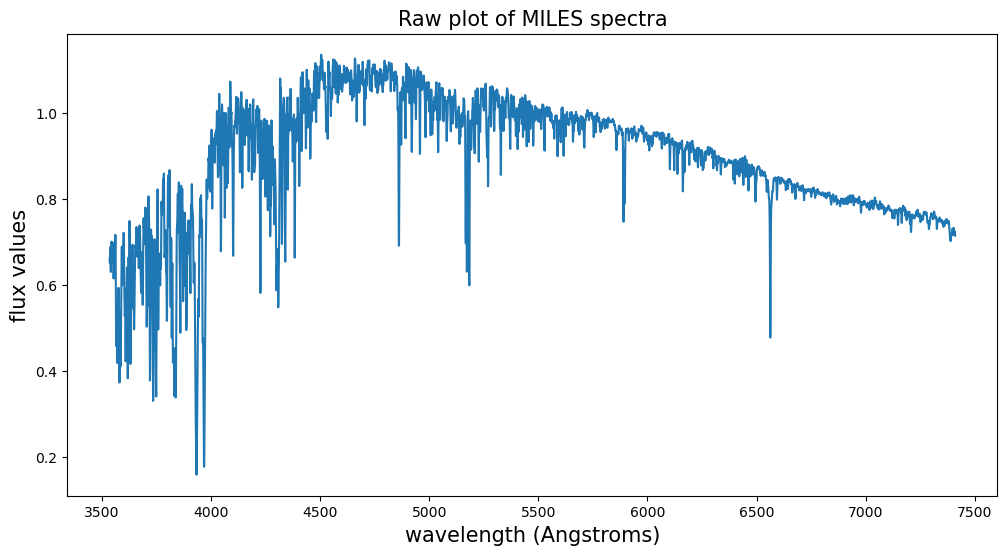

In [86]:
#plotting a raw spectrum
plt.figure(figsize=(12,6))
plt.title(f'Raw plot of MILES spectra', fontsize=15)
plt.plot(miles_wavelengths, miles_data_all.iloc[0].flux)
plt.xlabel('wavelength (Angstroms)', fontsize = 15)
plt.ylabel('flux values', fontsize=15)
plt.show()

--------
# 2. Loading CFLIB data 
https://noirlab.edu/science/observing-noirlab/observing-kitt-peak/telescope-and-instrument-documentation/cflib

- First loading in one file to check formatting

In [87]:
# Load the FITS file
cflib_file = fits.open('../data/CFLIB_Library/32147.fits')

In [88]:
cflib_file

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000001E30877BBD0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8ABC90>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8B9AD0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8BB790>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8C5450>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8C7250>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8D11D0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8D2E90>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8DCAD0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8DE750>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8E84D0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8EA290>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001E30A8F4210>]

In [89]:
cflib_file.info()

Filename: ../data/CFLIB_Library/32147.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     107   (15011,)   float32   
  1  c0002100004    1 ImageHDU       143   (3066, 1, 4)   float32   
  2  c0002140009    1 ImageHDU       107   (3066, 1, 4)   float32   
  3  c0002180032    1 ImageHDU       143   (3066, 1, 4)   float32   
  4  c9512140033    1 ImageHDU       143   (3060, 1, 4)   float32   
  5  c9512190143    1 ImageHDU       143   (3060, 1, 4)   float32   
  6  c9612170035    1 ImageHDU       143   (3066, 1, 4)   float32   
  7  a0002100004    1 ImageHDU       107   (3066, 1, 4)   float32   
  8  a0002140009    1 ImageHDU       107   (3066, 1, 4)   float32   
  9  a0002180032    1 ImageHDU       107   (3066, 1, 4)   float32   
 10  a9512140033    1 ImageHDU       143   (3060, 1, 4)   float32   
 11  a9512190143    1 ImageHDU       143   (3060, 1, 4)   float32   
 12  a9612170035    1 ImageHDU       143   (3066, 1, 4)   float32   


In [90]:
spectra_data = cflib_file[0].data
spectra_data

array([1.7034444e-01, 1.3221624e-01, 1.0830643e-01, ..., 9.9999997e-05,
       9.9999997e-05, 9.9999997e-05], dtype=float32)

In [91]:
spectra_data = spectra_data.tolist()

In [92]:
len(spectra_data)

15011

In [94]:
header_data = cflib_file[0].header
#header_data

**Observation**: header data appears to have a lot more information regarding the stellar properties, therefore only null values will be looked up in Simbad/vizier. <br>

Some CFLIB spectra also have gaps in the data that are flagged in the header file under the GAPS object. Any spectra that has a gap larger than 20 readings and is in the optical range (i.e 3537 - 7408) will be flagged and ultimately removed. 

In [95]:
header_data.get('GAPS')

In [96]:
objectID = header_data.get("OBJNAME")
objectID

'HD 32147'

In [97]:
coverage = header_data.get('COVERAGE')
teff = header_data.get('TEFF')
logg = header_data.get('LOGG')
metalicity = header_data.get('FEH')
sp_type = header_data.get('SPTYPE')

print(f'wavelength coverage: {coverage} Angstroms')
print(f'Effective temperature: {teff} Kelvin')
print(f'surface gravity: {logg} ')
print(f'metalicity: {metalicity} ')
print(f'MK Class: {sp_type} ')

wavelength coverage: 3465.0-9448.6 Angstroms
Effective temperature: 4625 Kelvin
surface gravity: 4.55 
metalicity: 0.28 
MK Class: K3V 


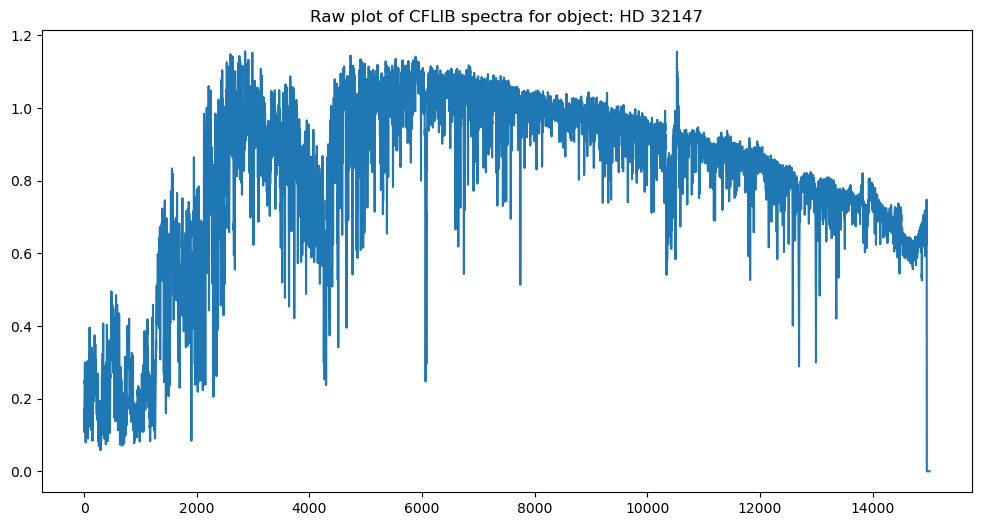

In [98]:
#plotting the spectrum of one star from the SDSS dataset
plt.figure(figsize=(12,6))
plt.title(f'Raw plot of CFLIB spectra for object: {objectID}')
plt.plot(spectra_data)
plt.show()

To keep the wavelength range consistent, I need to trim this down to be within the range determined from the MILES library:
i.e. 3536 - 7409 Angstroms

In [99]:
#header_data = cflib_file[0].header
#header_data

In [100]:
wave_start = header_data.get('CRVAL1')
wave_num = len(spectra_data)
wave_step = header_data.get('CDELT1')
wave_end = wave_start + (wave_num*wave_step)

In [101]:
wavelengths_cflib = np.arange(wave_start, wave_end, wave_step)

In [102]:
#triming flux values to relate to within MILES wavelength range
flux_indices= [i for i, value in enumerate(wavelengths_cflib) if (value >= 3536) and (value <= 7409)]

In [103]:
spectra_data = spectra_data[flux_indices[0]:flux_indices[-1]]
wavelengths_cflib = wavelengths_cflib[flux_indices[0]:flux_indices[-1]]

In [104]:
flux_indices[-1]

9859

In [105]:
flux_indices[0]

178

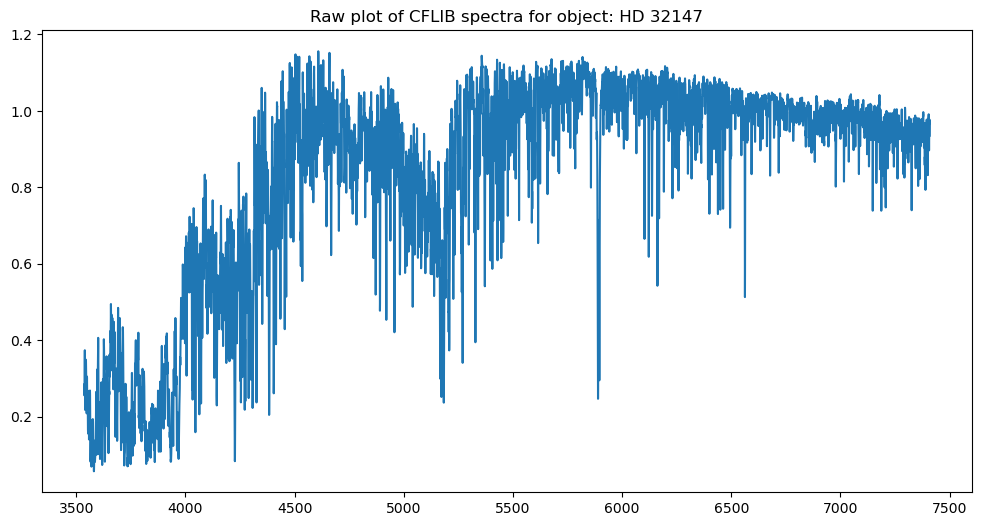

In [106]:
#plotting the spectrum of one star from the CFLIB dataset
plt.figure(figsize=(12,6))
plt.title(f'Raw plot of CFLIB spectra for object: {objectID}')
plt.plot(wavelengths_cflib, spectra_data)
plt.show()

##### Processing all cflib fits files

In [107]:
#defining directory where CFLIB files are stored
directory = '../data/CFLIB_Library/'

#initialising dictionary to store dataframes
spectra_dataframes = {}

#initialising a blank stellar parameter dataframe
stellar_params_df = pd.DataFrame({'object_id':[],'sp_type':[],'teff':[],'logg':[],'metallicity':[]})
stellar_params_df.set_index('object_id', inplace=True)

#initialising number of files iterator
i=0
#initialising onjectID list
objectIDs = []
#initialising the flags list - identifying where there are gaps in the data
gap_flags = []

for filename in os.listdir(directory):
    filepath = os.path.join(directory,filename)
    if os.path.isfile(filepath):
        # Load the FITS file
        #print(f'processing {filename}')
        with fits.open(filepath) as fits_file:
            fits_file = fits.open(filepath)
            
            #verifying fix format to resolve parsing error previously encountered
            fits_file[0].verify('fix')
            
            #extracting spectra data from fits file
            spectra_data = fits_file[0].data
            spectra_data = spectra_data.tolist()
            
            #getting the object name 
            header_data = fits_file[0].header
            spectra_object = header_data.get("OBJNAME")
            
            #checking the gaps in the data and creating a flag variable if data missing in 
            #optical range/ > 10 readings
            gaps = (header_data).get('GAPS')
            if gaps != None:
                for gap in gaps.split(','):
                    vals = gap.split('-')
                    min_val, max_val = float(vals[0]), float(vals[1])
                    diff = max_val - min_val 
                    if (diff > 20) and (3536 <= min_val <= 7409):
                        flag = True
                    else:
                        flag = False
            else: 
                flag = False
                
            #checking that the wavelength coverage is between 3536 and 7409, 
            #if not update flag to be True
            coverage = header_data.get('COVERAGE').split('-')
            min_cov, max_cov = float(min(coverage)), float(max(coverage))
            if (min_cov > 3536) or (max_cov < 7409):
                flag = True
                                                        
            spectra_data = spectra_data[178:9859]

            #creating a dataframe containing both wavelength and flux values
            spectra_vecs =  pd.DataFrame({'wavelength':wavelengths_cflib,'flux':spectra_data}) 
            #creating a dataframe containing the derived stellar parameters and MK classes
            stellar_p_df = pd.DataFrame({'object_id':[spectra_object],
                                         'sp_type':[str(header_data.get('SPTYPE'))],
                                         'teff':[str(header_data.get('TEFF'))],
                                         'logg':[str(header_data.get('LOGG'))],
                                         'metallicity':[str(header_data.get('FEH'))]})
            stellar_p_df.set_index('object_id', inplace=True)
            
            #merging to stellar_params_df
            stellar_params_df = pd.concat([stellar_params_df, stellar_p_df])
            
            #creating a dictionary of dataframes
            spectra_dataframes['df_'+spectra_object] = spectra_vecs
            
            #appending specIDs to array
            objectIDs.append(spectra_object)
            
            #append gap
            gap_flags.append(flag)
            
        i+=1
        
print(f'finished processing {i} files')

finished processing 1273 files


In [108]:
stellar_params_df.head()

,sp_type,teff,logg,metallicity
object_id,,,,
HD 100006,K0III,4755,3.0,0.02
HD 100030,G9IV,5027,2.6,-0.29
HD 100446,F8,5967,4.29,-0.48
HD 100470,K0III,4667,2.5,-0.4
HD 100563,F5V,6423,4.31,-0.02


In [113]:
#creating dataframe consisting of objectID and flux values
flux_cflib = pd.DataFrame({'objectID':[],'flux':[]})

for key,value in spectra_dataframes.items():
    objectID = key[3:]
    new_df = pd.DataFrame({'objectID':objectID,'flux':[list(value.flux)]})
    flux_cflib = pd.concat([flux_cflib, new_df])

flux_cflib.set_index('objectID', inplace=True)  

In [114]:
#merging spectra and stellar params datasets
cflib_data_all = pd.merge(stellar_params_df, flux_cflib, left_index=True, right_index=True)

In [115]:
cflib_data_all.head()

,sp_type,teff,logg,metallicity,flux
HD 100006,K0III,4755,3.0,0.02,"[0.24178585410118103, 0.24195635318756104, 0.2..."
HD 100030,G9IV,5027,2.6,-0.29,"[0.37486782670021057, 0.3697386682033539, 0.36..."
HD 100446,F8,5967,4.29,-0.48,"[0.6483952403068542, 0.6578622460365295, 0.659..."
HD 100470,K0III,4667,2.5,-0.4,"[0.2565902769565582, 0.2529727518558502, 0.244..."
HD 100563,F5V,6423,4.31,-0.02,"[0.773551344871521, 0.7820722460746765, 0.7895..."


In [116]:
#checking where any parameter is INDEF from CFLIB library
cflib_data_all[cflib_data_all['teff'] == 'INDEF']

,sp_type,teff,logg,metallicity,flux
HD 100889,B9.5Vn,INDEF,INDEF,INDEF,"[1.1903361082077026, 1.186834692955017, 1.1889..."
HD 103287,A0V,INDEF,INDEF,INDEF,"[0.9256237149238586, 0.9290333986282349, 0.927..."
HD 10362,B7II,INDEF,INDEF,INDEF,"[2.333897352218628, 2.3575985431671143, 2.3260..."
HD 106591,A3V,INDEF,INDEF,INDEF,"[0.8197053670883179, 0.8179162740707397, 0.821..."
HD 109387,B6IIIpe,INDEF,INDEF,INDEF,"[2.090707540512085, 2.1010539531707764, 2.0997..."
...,...,...,...,...,...
HD 49601,K2,INDEF,INDEF,INDEF,"[0.3606400191783905, 0.32816281914711, 0.34758..."
HD 173739,M3V,INDEF,INDEF,INDEF,"[0.13967794179916382, 0.1416572779417038, 0.13..."
HD 48948,K5,INDEF,INDEF,INDEF,"[0.17921628057956696, 0.17330889403820038, 0.1..."
SAO 60116,K2V,INDEF,INDEF,INDEF,"[0.32290777564048767, 0.3084615468978882, 0.29..."


In [117]:
#Updating these 'INDEF' values to null values, so the combine_first function can be applied
param_cols = ['sp_type','teff', 'logg', 'metallicity']
cflib_data_all[param_cols] = cflib_data_all[param_cols].applymap(lambda x: None if x == 'INDEF' else x)

In [118]:
cflib_data_all[cflib_data_all.isnull().any(axis=1)]

,sp_type,teff,logg,metallicity,flux
HD 100889,B9.5Vn,None,None,None,"[1.1903361082077026, 1.186834692955017, 1.1889..."
HD 103287,A0V,None,None,None,"[0.9256237149238586, 0.9290333986282349, 0.927..."
HD 10362,B7II,None,None,None,"[2.333897352218628, 2.3575985431671143, 2.3260..."
HD 106591,A3V,None,None,None,"[0.8197053670883179, 0.8179162740707397, 0.821..."
HD 109387,B6IIIpe,None,None,None,"[2.090707540512085, 2.1010539531707764, 2.0997..."
...,...,...,...,...,...
HD 173739,M3V,None,None,None,"[0.13967794179916382, 0.1416572779417038, 0.13..."
HD 48948,K5,None,None,None,"[0.17921628057956696, 0.17330889403820038, 0.1..."
HD 17382,K1V,5425,None,0.21,"[0.30277514457702637, 0.29439523816108704, 0.2..."
SAO 60116,K2V,None,None,None,"[0.32290777564048767, 0.3084615468978882, 0.29..."


In [119]:
## querying SIMBAD for missing params
null_obj = list(cflib_data_all[cflib_data_all.isnull().any(axis=1)].index)

#adding fields to be returned from query
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype', 'fe_h') 

simbad_results = pd.DataFrame({'object_id':[],'teff':[],'logg':[],'metallicity':[]})
simbad_results.set_index('object_id', inplace=True)

In [120]:
for missing_obj in null_obj:
    res = customSimbad.query_object(missing_obj)
    if not res is None:
        res = res.to_pandas()
        res = res[['SP_TYPE','Fe_H_Teff','Fe_H_log_g','Fe_H_Fe_H']]
        res.columns = ['sp_type', 'teff', 'logg',  'metallicity']
        res['object_id'] = missing_obj
    elif res is None:
        res = pd.DataFrame({'object_id':[missing_obj],'sp_type':[None],'teff':[None],'logg':[None],'metallicity':[None]})
    res.set_index('object_id', inplace=True)
    simbad_results = pd.concat([simbad_results, res])

In [66]:
simbad_results.head()

,teff,logg,metallicity,sp_type
object_id,,,,
HD 100889,12100.0,4.00,NaN,B9.5V
HD 103287,9390.0,NaN,NaN,A0Ve+K2V
HD 10362,0.0,NaN,NaN,B7III
HD 106591,8100.0,3.60,-0.60,A2Vn
HD 109387,16906.0,3.19,-0.12,B6IIIe


In [121]:
#filling null values from stellar_params with non_null values got from vizier
cflib_data_all = cflib_data_all.combine_first(simbad_results)

In [122]:
#removing any remaining null values for sp_type
cflib_data_all[cflib_data_all['sp_type'].isnull()]

,flux,logg,metallicity,sp_type,teff


In [123]:
#finally removing any spectra that are flagged with having missing readings
gap_flag_df = pd.DataFrame({'objectID':objectIDs, 'flags':gap_flags, 'filename':filename})
remove_objectid_list = list(gap_flag_df[gap_flag_df['flags']==True].objectID)

In [124]:
a = len(cflib_data_all)
cflib_data_all.drop(remove_objectid_list, inplace=True)
b = a - len(cflib_data_all)

print(f'removing {b} rows from cflib_data_all with missing readings')

removing 306 rows from cflib_data_all with missing readings


In [126]:
#saving as csv
#cflib_data_all.to_csv('../data/derived_tables/cflib_data')

#saving as pickle file
cflib_data_all.to_pickle('../data/derived_tables/cflib_data.pkl')

#saving wavelengths to csv 
pd.DataFrame({'wavelength':wavelengths_cflib}).to_csv('../data/derived_tables/cflib_wave.csv')

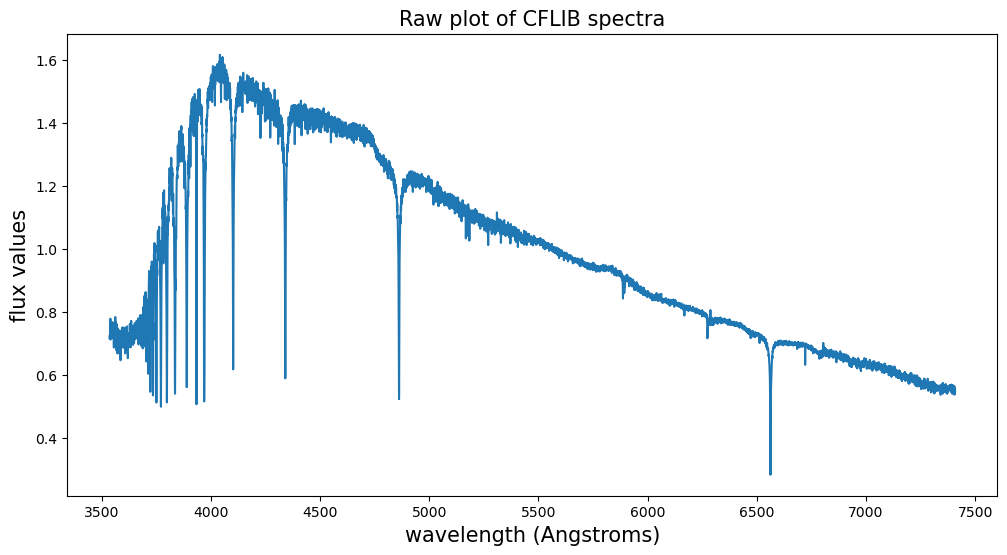

In [128]:
#plotting a raw spectrum
plt.figure(figsize=(12,6))
plt.title(f'Raw plot of CFLIB spectra', fontsize=15)
plt.plot(wavelengths_cflib, cflib_data_all.iloc[0].flux)
plt.xlabel('wavelength (Angstroms)', fontsize = 15)
plt.ylabel('flux values', fontsize=15)
plt.show()

--------
# 3.  Loading JHC Atlas data 
https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/jacoby-hunter-christian-atlas

In [129]:
# Load the FITS file
jhc_file = fits.open('../data/JHCAtlas_Library/jc_1.fits')

In [130]:
jhc_file.info()

Filename: ../data/JHCAtlas_Library/jc_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   ()      
  1                1 BinTableHDU     28   2799R x 5C   [1E, 1E, 1E, 1E, 1E]   


In [131]:
spectra_data = jhc_file[1].data
spectra_data

FITS_rec([(3510.    , 2.851e-11, nan, nan, nan),
          (3511.4   , 2.872e-11, nan, nan, nan),
          (3512.8   , 2.899e-11, nan, nan, nan), ...,
          (7424.4   , 1.951e-12, nan, nan, nan),
          (7425.8003, 1.919e-12, nan, nan, nan),
          (7427.2   , 1.927e-12, nan, nan, nan)],
         dtype=(numpy.record, [('WAVELENGTH', '>f4'), ('FLUX', '>f4'), ('STATERROR', '>f4'), ('SYSERROR', '>f4'), ('FWHM', '>f4')]))

In [132]:
header_data = jhc_file[0].header
header_data

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
ORIGIN  = 'STScI-STSDAS/TABLES' / Tables version 1999-03-22                     
FILENAME= 'jc_1.fits'          / name of file                                   
DESCRIP = '= ''Jacobi-Christenson atlas'''                                      
DBTABLE = '= ''CRGRIDS'''                                                       
OBSMODE = '= '' '' '        

In [133]:
jhc_df = pd.DataFrame(spectra_data)
jhc_df.head()

,WAVELENGTH,FLUX,STATERROR,SYSERROR,FWHM
0,3510.000000,2.851000e-11,NaN,NaN,NaN
1,3511.399902,2.872000e-11,NaN,NaN,NaN
2,3512.800049,2.899000e-11,NaN,NaN,NaN
3,3514.199951,2.903000e-11,NaN,NaN,NaN
4,3515.600098,2.890000e-11,NaN,NaN,NaN


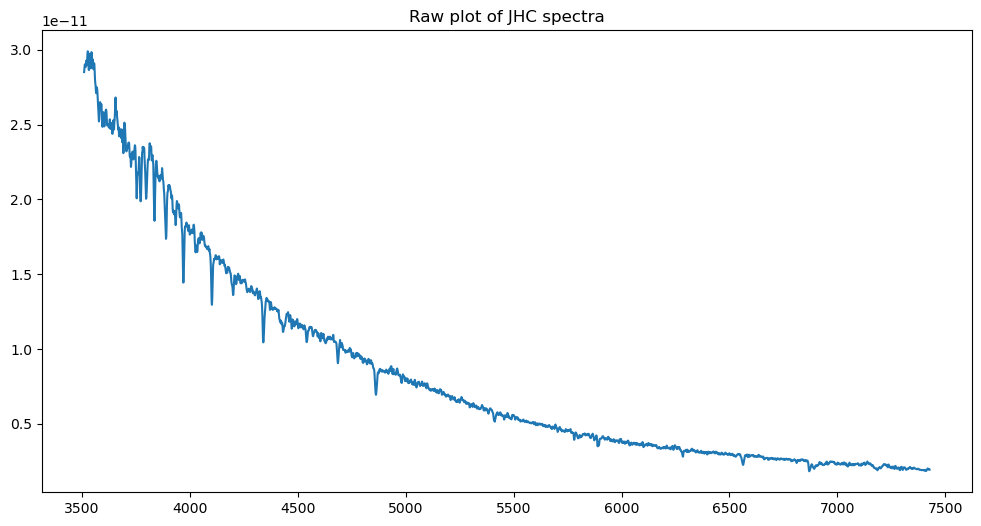

In [134]:
#plotting the spectrum of one star from the JHC dataset
plt.figure(figsize=(12,6))
plt.title('Raw plot of JHC spectra')
plt.plot(jhc_df['WAVELENGTH'] ,jhc_df['FLUX'])
plt.show()

**NOTE**: for JHC files there is no stellar parameter/objectID information available within the fits files header. This information is provided directly on the JHC catalog webpage, which has been loaded in as a csv below to be mapped to each spectra.

In [136]:
jhc_params = pd.read_csv('../data/JHCAtlas_Library/jhc_atlas_mappings.csv',header=None)
jhc_params.columns = ['filename','object_id','sp_type']
jhc_params.set_index('object_id', inplace=True)
jhc_params.head()

,filename,sp_type
object_id,,
HD 242908,jc_1.fits,O5 V
HD 215835,jc_2.fits,O5.5 V
HD 12993,jc_3.fits,O6.5 V
HD 35619,jc_4.fits,O7 V
HD 44811,jc_5.fits,O7.5 V


In [137]:
jhc_obj_list = list(jhc_params.index)

#adding fields to be returned from query
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype', 'fe_h') 

simbad_results = pd.DataFrame({'object_id':[],'teff':[],'logg':[],'metallicity':[]})
simbad_results.set_index('object_id', inplace=True)

In [138]:
for obj in jhc_obj_list:
    res = customSimbad.query_object(obj)
    if not res is None:
        res = res.to_pandas()
        res = res[['Fe_H_Teff','Fe_H_log_g','Fe_H_Fe_H']]
        res.columns = ['teff', 'logg',  'metallicity']
        res['object_id'] = obj
    elif res is None:
        res = pd.DataFrame({'object_id':[obj],'teff':[None],'logg':[None],'metallicity':[None]})
    res.set_index('object_id', inplace=True)
    simbad_results = pd.concat([simbad_results, res])

simbad_results.head()

,teff,logg,metallicity
object_id,,,
HD 242908,0.0,NaN,NaN
HD 215835,0.0,NaN,NaN
HD 12993,39200.0,3.89,NaN
HD 35619,37700.0,3.94,NaN
HD 44811,37400.0,3.90,NaN


In [139]:
jhc_params = pd.merge(jhc_params, simbad_results, left_index =True, right_index=True)

In [140]:
jhc_params = jhc_params.reset_index().set_index('filename')
jhc_params.head()

,object_id,sp_type,teff,logg,metallicity
filename,,,,,
jc_128.fits,42 LSI,A2 I,NaN,NaN,NaN
jc_112.fits,BD +19 1947,M3 II,0.0,NaN,NaN
jc_90.fits,BD +28 1885,G5 III,0.0,NaN,NaN
jc_87.fits,BD +30 2347,G0 III,5910.0,3.95,NaN
jc_113.fits,BD +36 1967,M7 II,0.0,NaN,NaN


In [141]:
#defining directory where CFLIB files are stored
directory_jhc = '../data/JHCAtlas_Library/'

#initialising dictionary to store dataframes
spectra_dataframes_jhc = {}

#initialising number of files iterator
i=0

#initialising onjectID list
objectIDs_jhc = []

#the slicing [:-2] excludes the two non spectra files stored in the directory
for filename in os.listdir(directory_jhc)[:-2]:
    filepath = os.path.join(directory_jhc,filename)
    if os.path.isfile(filepath):
        # Load the FITS file
        #print(f'processing {filename}')
        with fits.open(filepath) as fits_file:
            fits_file = fits.open(filepath)
            
            #extracting spectra data from fits file
            spectra_data =  pd.DataFrame(fits_file[1].data).FLUX
            spectra_data = spectra_data.tolist()
            
            wavelength_data =  pd.DataFrame(fits_file[1].data).WAVELENGTH
            wavelength_data = wavelength_data.tolist()
            
            #getting the object name from jhc_params using filename as lookup
            #there are some duplicte object_ids in the data hence the below if/else statement
            if len(jhc_params.loc[filename].object_id) == 2:
                spectra_object = jhc_params.loc[filename].object_id[0]
            else: 
                spectra_object = jhc_params.loc[filename].object_id
            
            #creating a dataframe containing both wavelength and flux values
            spectra_vecs =  pd.DataFrame({'wavelength':wavelength_data,'flux':spectra_data}) 
            
            #creating a dictionary of dataframes
            spectra_dataframes_jhc['df_'+spectra_object] = spectra_vecs
            
            #appending specIDs to array
            objectIDs_jhc.append(spectra_object)
        i+=1
        
print(f'finished processing {i} files')

finished processing 161 files


In [142]:
#creating dataframe consisting of objectID and flux values
flux_jhc = pd.DataFrame({'objectID':[],'flux':[]})

for key,value in spectra_dataframes_jhc.items():
    objectID = key[3:]
    new_df = pd.DataFrame({'objectID':objectID,'flux':[list(value.flux)]})
    flux_jhc = pd.concat([flux_jhc, new_df])

flux_jhc.set_index('objectID', inplace=True)  

In [143]:
#setting index on jhc stellar params to object_id so it can be merged to flux values
jhc_params.set_index('object_id', inplace=True)

In [144]:
#merging spectra and stellar params datasets
jhc_data_all = pd.merge(jhc_params, flux_jhc, left_index=True, right_index=True)

jhc_data_all.head()

,sp_type,teff,logg,metallicity,flux
42 LSI,A2 I,NaN,NaN,NaN,"[1.398999948006019e-12, 1.3389999829402366e-12..."
BD +19 1947,M3 II,0.0,NaN,NaN,"[4.14199992121618e-14, 3.3739998913252106e-14,..."
BD +28 1885,G5 III,0.0,NaN,NaN,"[1.510999983987682e-13, 1.599999971922672e-13,..."
BD +30 2347,G0 III,5910.0,3.95,NaN,"[1.2069999947433852e-13, 1.172999956715326e-13..."
BD +36 1967,M7 II,0.0,NaN,NaN,"[7.149000087660479e-14, 4.9800001091209606e-14..."


In [164]:
#jhc_data_all.to_csv('../data/derived_tables/jhc_data')

#saving as pickle file
jhc_data_all.to_pickle('../data/derived_tables/jhc_data.pkl')

#saving jhc wavelength values to csv
jhc_df.WAVELENGTH.to_csv('../data/derived_tables/jhc_wave.csv')

In [187]:
jhc_df.WAVELENGTH[0], jhc_df.WAVELENGTH[-1:]

(3510.0,
 2798    7427.200195
 Name: WAVELENGTH, dtype: float32)

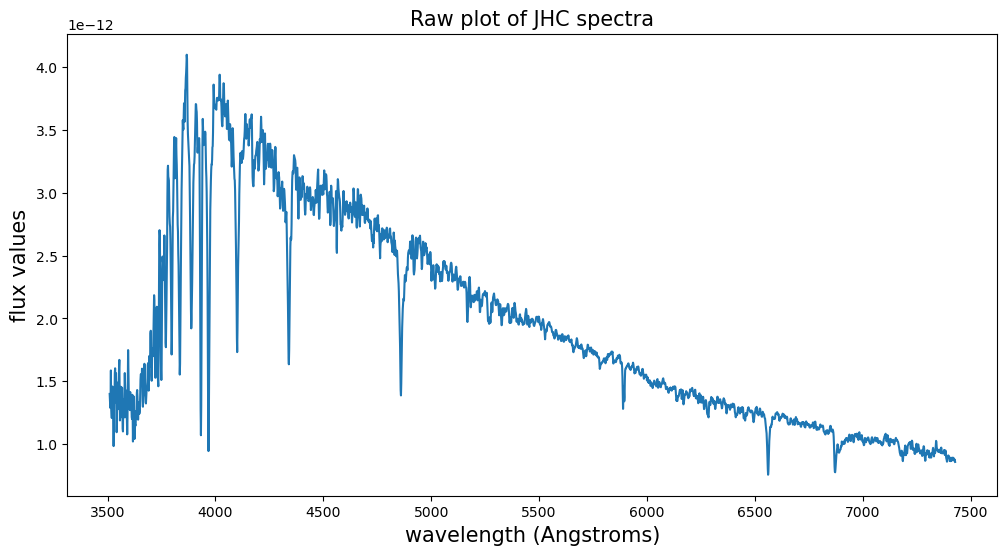

In [166]:
#plotting a raw spectrum
plt.figure(figsize=(12,6))
plt.title(f'Raw plot of JHC spectra', fontsize=15)
plt.plot(jhc_df.WAVELENGTH, jhc_data_all.iloc[0].flux)
plt.xlabel('wavelength (Angstroms)', fontsize = 15)
plt.ylabel('flux values', fontsize=15)
plt.show()

--------
# 4.  Loading the LAMOST data
https://www.lamost.org/dr9/

In [188]:
#defining directory where CFLIB files are stored
directory_lamost = '../data/LAMOST_data/'

In [189]:
# Path to the .fits.gz file
file_path = '../data/LAMOST_data/spec-55922-B5592206_sp04-084.fits.gz'

#opening the gzip file as this is the format it is downloaded from LAMOST
with gzip.open(file_path, 'rb') as f:
    #extracting the contents of the .fits file from within the gzip
    with fits.open(f) as lamost_data:
        header = lamost_data[0].header
        data = lamost_data[1].data

In [190]:
data.dtype

dtype((numpy.record, [('FLUX', '>f4', (3904,)), ('IVAR', '>f4', (3904,)), ('WAVELENGTH', '>f4', (3904,)), ('ANDMASK', '>f4', (3904,)), ('ORMASK', '>f4', (3904,)), ('NORMALIZATION', '>f4', (3904,))]))

In [191]:
data.dtype.names

('FLUX', 'IVAR', 'WAVELENGTH', 'ANDMASK', 'ORMASK', 'NORMALIZATION')

In [192]:
data_dict = {name: data.field(name).flatten() for name in data.dtype.names}
data_dict

{'FLUX': array([ 19.890936, 153.14503 , 109.613266, ...,   0.      ,   0.      ,
          0.      ], dtype=float32),
 'IVAR': array([1.5185605e-04, 1.6597021e-04, 1.6699413e-04, ..., 4.1322234e-01,
        4.1322234e-01, 4.1322234e-01], dtype=float32),
 'WAVELENGTH': array([3699.9863, 3700.8384, 3701.6907, ..., 9084.48  , 9086.573 ,
        9088.665 ], dtype=float32),
 'ANDMASK': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'ORMASK': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'NORMALIZATION': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.], dtype=float32)}

In [193]:
lamost_df = pd.DataFrame(data_dict)
lamost_df.head()

,FLUX,IVAR,WAVELENGTH,ANDMASK,ORMASK,NORMALIZATION
0,19.890936,0.000152,3699.986328,0.0,0.0,-9999.0
1,153.145035,0.000166,3700.838379,0.0,0.0,-9999.0
2,109.613266,0.000167,3701.690674,0.0,0.0,-9999.0
3,158.028366,0.000157,3702.542969,0.0,0.0,-9999.0
4,-53.330273,0.000169,3703.395752,0.0,0.0,-9999.0


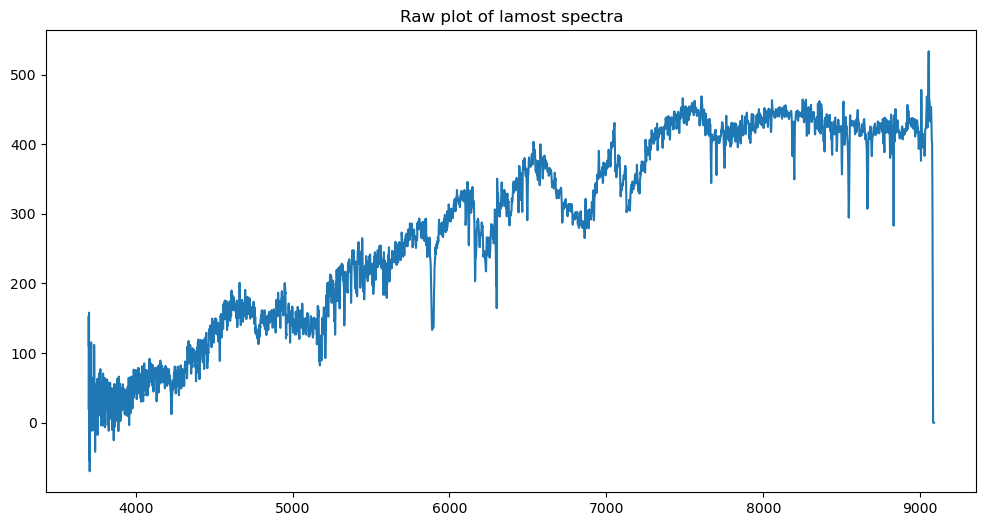

In [194]:
#plotting the spectrum of one star from the JHC dataset
plt.figure(figsize=(12,6))
plt.title('Raw plot of lamost spectra')
plt.plot(lamost_df['WAVELENGTH'] ,lamost_df['FLUX'])
plt.show()

In [195]:
#checking the header to see if the subclass can be extracted
#header

In [196]:
header.get('SUBCLASS')

'M0'

In [197]:
#defining directory where LAMOST files are stored
directory_lamost = '../data/LAMOST_data/'

#initialising dictionary to store dataframes
spectra_dataframes_lamost = {}

#initialising a blank stellar parameter dataframe
lamost_params_df = pd.DataFrame({'object_id':[],'sp_type':[], 'start_wave':[], 'end_wave':[], 'wave_step':[],
                                 'len_wave':[]})
lamost_params_df.set_index('object_id', inplace=True)

#initialising number of files iterator
i=0


for filename in os.listdir(directory_lamost):
    filepath = os.path.join(directory_lamost, filename)
    if os.path.isfile(filepath):
        #opening the gzip file as this is the format it is downloaded from LAMOST
        with gzip.open(filepath, 'rb') as f:
            #extracting the contents of the .fits file from within the gzip
            with fits.open(f) as lamost_data:
                header = lamost_data[0].header
                data = lamost_data[1].data

                #converting contents of data to dictionary to be converted to dataframe
                data_dict = {name: data.field(name).flatten() for name in data.dtype.names}
                lamost_data = pd.DataFrame(data_dict)
                #extracting spectra data from fits file
                spectra_data =  lamost_data.FLUX
                spectra_data = spectra_data.tolist()

                wavelength_data =  lamost_data.WAVELENGTH
                wavelength_data = wavelength_data.tolist()
                wave_step = round(abs(wavelength_data[0] - wavelength_data[1]), 2)
                
                spectra_object = header.get('OBSID')
                sp_type = header.get('SUBCLASS')

                #creating a dataframe containing both wavelength and flux values
                spectra_vecs =  pd.DataFrame({'wavelength':wavelength_data,'flux':spectra_data}) 
                
                #not interested in any wavelength values after 8000 Angstroms
                spectra_vecs = spectra_vecs[spectra_vecs['wavelength']<=8000]
                
                wavelength_data = spectra_vecs.wavelength.values
                #creating a dictionary of dataframes
                spectra_dataframes_lamost['df_'+str(spectra_object)] = spectra_vecs

                stellar_p_df = pd.DataFrame({'object_id':[str(spectra_object)],
                                             'sp_type':[sp_type], 
                                             'start_wave':[wavelength_data[0]],
                                             'end_wave':[wavelength_data[-1]],
                                             'wave_step':[wave_step] ,
                                             'len_wave':[len(wavelength_data)]})
                stellar_p_df.set_index('object_id', inplace=True)

                #merging to stellar_params_df
                lamost_params_df = pd.concat([lamost_params_df, stellar_p_df])
        i+=1
        
print(f'finished processing {i} files')

finished processing 205 files


In [198]:
lamost_params_df['start_wave'].unique()

array([3699.98632812, 3700.        ])

In [199]:
lamost_params_df[lamost_params_df['start_wave'] == 3700.000000]

,sp_type,start_wave,end_wave,wave_step,len_wave
object_id,,,,,
212016,A7,3700.0,7998.374512,0.85,3349.0


In [200]:
#removing record with wavelength range discrepency
lamost_params_df = lamost_params_df[lamost_params_df['start_wave'] != 3700.000000]

In [201]:
#removing record also from dictionary
del spectra_dataframes_lamost['df_212016']

In [202]:
lamost_params_df['start_wave'].unique(), lamost_params_df['end_wave'].unique(), lamost_params_df['wave_step'].unique()

(array([3699.98632812]), array([7998.34472656]), array([0.85]))

In [203]:
lamost_params_df = lamost_params_df[['sp_type']]

In [204]:
#creating dataframe consisting of objectID and flux values
flux_lamost = pd.DataFrame({'objectID':[],'flux':[]})

for key,value in spectra_dataframes_lamost.items():
    objectID = key[3:]
    new_df = pd.DataFrame({'objectID':objectID,'flux':[list(value.flux)]})
    flux_lamost = pd.concat([flux_lamost, new_df])

flux_lamost.set_index('objectID', inplace=True)  

In [205]:
#merging spectra and stellar params datasets
lamost_data_all = pd.merge(lamost_params_df, flux_lamost, left_index=True, right_index=True)

lamost_data_all.head()

,sp_type,flux
11204096,B6,"[21777.73828125, 21737.06640625, 22440.4941406..."
1202048,A5,"[1409.0521240234375, 1390.9801025390625, 1308...."
1207018,A6,"[1709.0643310546875, 1711.9002685546875, 1594...."
1214098,A7,"[882.8451538085938, 1021.5106201171875, 933.67..."
1402064,A7,"[802.8242797851562, 822.854248046875, 774.6330..."


In [206]:
#saving as pickle file
lamost_data_all.to_pickle('../data/derived_tables/lamost_data.pkl')

#saving jhc wavelength values to csv
lamost_wave = spectra_dataframes_lamost['df_203143'].wavelength
lamost_wave.to_csv('../data/derived_tables/lamost_wave.csv')

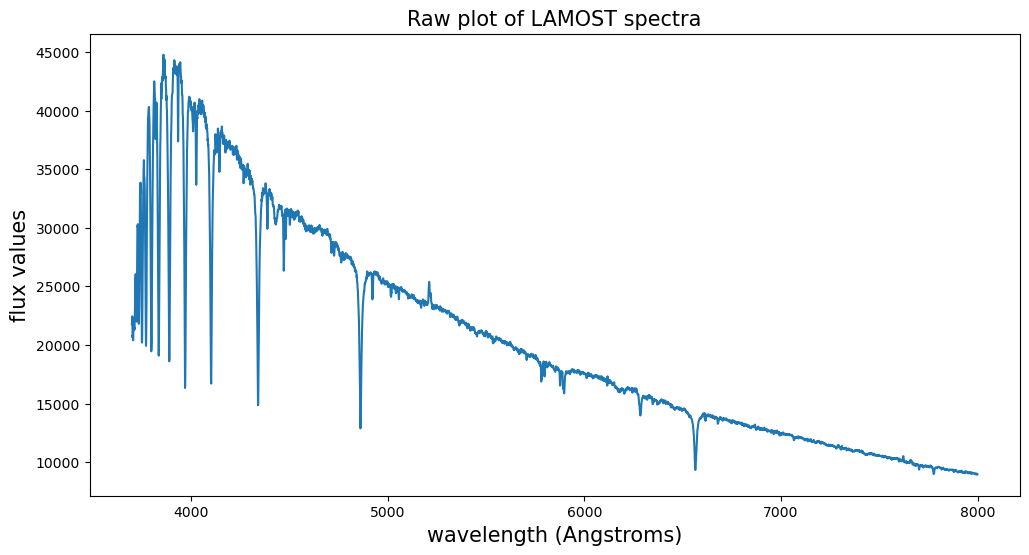

In [209]:
#plotting a raw spectrum
plt.figure(figsize=(12,6))
plt.title(f'Raw plot of LAMOST spectra', fontsize=15)
plt.plot(lamost_wave, lamost_data_all.iloc[0].flux)
plt.xlabel('wavelength (Angstroms)', fontsize = 15)
plt.ylabel('flux values', fontsize=15)
plt.show()